In [22]:
# Installs
!pip install -q ydata-profiling shap scikit-learn==1.4.2

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, shap, scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

sns.set_style("whitegrid"); shap.initjs()


In [23]:
#read first 10 columns
df = pd.read_csv("/content/2023-yangin.csv", encoding="utf-8-sig")
print("First 10 columns:", df.columns[:10].to_list())


First 10 columns: ['_id', 'TARIH', 'YANGIN_TURU', 'YANGIN_SEBEBI', 'YANGIN_SONUCU', 'YAPI_SEKLI', 'ERKEK_VEFAT', 'KADIN_VEFAT', 'ITFAIYECI_VEFAT', 'ERKEK_YARALI']


In [24]:
#clean rows
df["TARIH"] = pd.to_datetime(df["TARIH"], errors="coerce")
df["call_hour"] = df["TARIH"].dt.hour

df["response_minutes"] = pd.to_numeric(df["VARIS_SURESI (DAK.)"], errors="coerce")

central = ["KONAK","KARABAĞLAR","BORNOVA","BUCA","KARŞIYAKA",
           "ÇİĞLİ","GAZİEMİR","BALÇOVA"]
df["ILCE"] = df["ILCE"].str.upper().str.strip()
df["district_group"] = np.where(df["ILCE"].isin(central), "Central", "Periphery")

df = df.dropna(subset=["response_minutes","call_hour","YANGIN_TURU"])
df = df[df["response_minutes"] > 0]
print("Rows after cleaning:", len(df))


Rows after cleaning: 12366


In [26]:
#info
df.info()
print("\nTop fire types:\n", df["YANGIN_TURU"].value_counts().head())
print("\nDistrict group counts:\n", df["district_group"].value_counts())


<class 'pandas.core.frame.DataFrame'>
Index: 12366 entries, 0 to 12378
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   _id                                       12366 non-null  int64         
 1   TARIH                                     12366 non-null  datetime64[ns]
 2   YANGIN_TURU                               12366 non-null  object        
 3   YANGIN_SEBEBI                             12366 non-null  object        
 4   YANGIN_SONUCU                             12366 non-null  object        
 5   YAPI_SEKLI                                2868 non-null   object        
 6   ERKEK_VEFAT                               12366 non-null  int64         
 7   KADIN_VEFAT                               12366 non-null  int64         
 8   ITFAIYECI_VEFAT                           12366 non-null  int64         
 9   ERKEK_YARALI                     

count    12366.000000
mean         5.928675
std         13.910072
min          1.000000
25%          3.000000
50%          5.000000
75%          6.000000
max       1445.000000
Name: response_minutes, dtype: float64


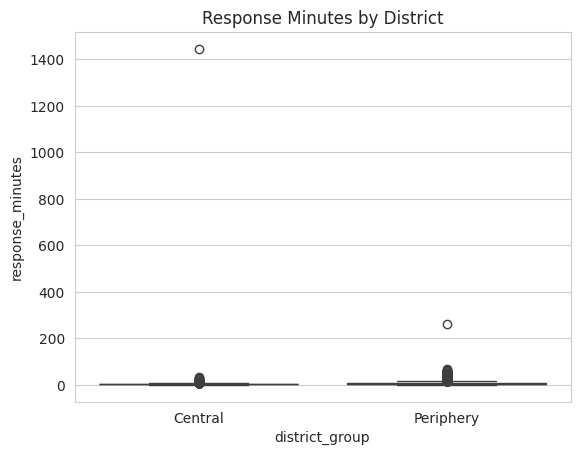

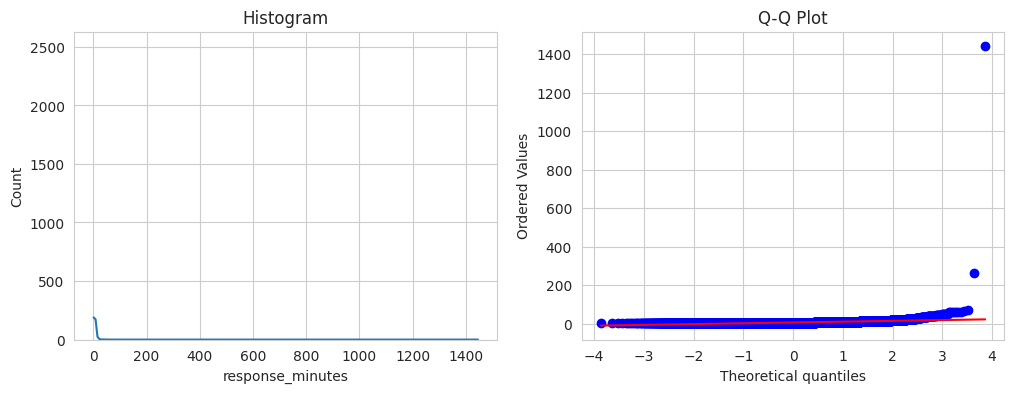

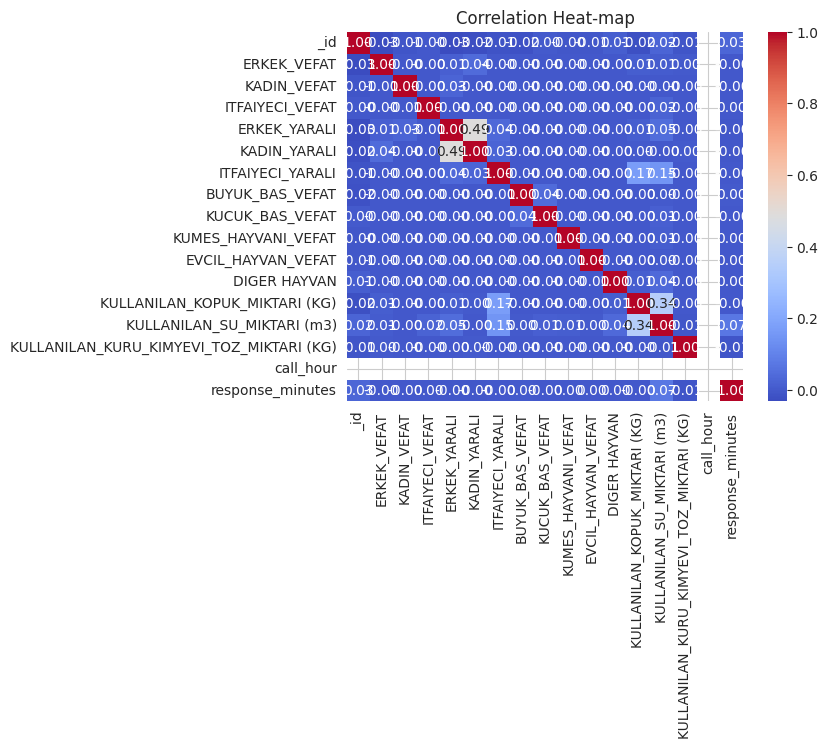

In [27]:
#graphs
print(df["response_minutes"].describe())

# Box-plot
sns.boxplot(x="district_group", y="response_minutes", data=df)
plt.title("Response Minutes by District"); plt.show()

# Histogram + QQ
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df["response_minutes"], kde=True, ax=ax[0]); ax[0].set_title("Histogram")
stats.probplot(df["response_minutes"], dist="norm", plot=ax[1]); ax[1].set_title("Q-Q Plot")
plt.show()

# Correlation heat-map
sns.heatmap(df.select_dtypes("number").corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heat-map"); plt.show()


In [31]:
#tests
p_normal = stats.shapiro(df["response_minutes"].sample(500, random_state=1))[1]
u, p = stats.mannwhitneyu(df[df["district_group"]=="Central"]["response_minutes"],
                          df[df["district_group"]=="Periphery"]["response_minutes"],
                          alternative="two-sided")
print(f"Shapiro p = {p_normal:.8f}")
print(f"Mann–Whitney p = {p:.8e}")


Shapiro p = 0.00000000
Mann–Whitney p = 0.00000000e+00


In [29]:
#ML
features = ["district_group", "YANGIN_TURU", "call_hour"]
X, y = df[features], df["response_minutes"]

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["district_group","YANGIN_TURU"]),
    ("num", StandardScaler(), ["call_hour"])
])
rf  = RandomForestRegressor(n_estimators=200, random_state=42)
pipe= Pipeline([("pre", pre), ("rf", rf)])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
pipe.fit(X_tr, y_tr)
print("Test MAE:", mean_absolute_error(y_te, pipe.predict(X_te)))
print("Test  R²:", r2_score(y_te, pipe.predict(X_te)))

cv_mae = -cross_val_score(pipe, X, y, cv=5,
                          scoring="neg_mean_absolute_error").mean()
print("5-fold CV MAE:", cv_mae)


Test MAE: 2.3838791402720734
Test  R²: 0.18074567727030855
5-fold CV MAE: 2.6546036237762585


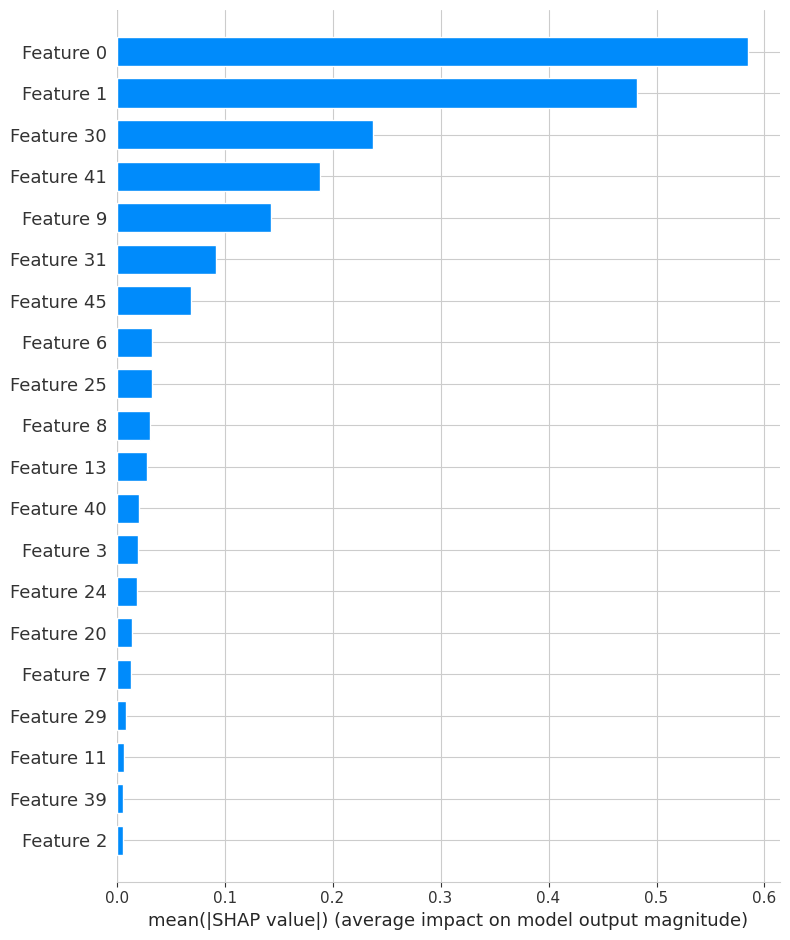

In [30]:
#shap
X_enc = pipe.named_steps["pre"].transform(X).toarray().astype(np.float32)
explainer   = shap.TreeExplainer(pipe.named_steps["rf"])
shap_values = explainer.shap_values(X_enc[:200])
shap.summary_plot(shap_values, X_enc[:200], plot_type="bar")
